In [1]:
import os
import time
import warnings
from tqdm.auto import tqdm

#----------------------------------------------------------#

import numpy as np
import pandas as pd

#----------------------------------------------------------#

import seaborn as sns
import matplotlib.pyplot as plt

#----------------------------------------------------------#

from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             ConfusionMatrixDisplay)

#----------------------------------------------------------#

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

#----------------------------------------------------------#

warnings.filterwarnings('ignore')
print(f'PyTorch Version: {torch.__version__}')

PyTorch Version: 2.5.1+cu121


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Current Device: {device}.')

Current Device: cuda.


In [3]:
# variables

root = '/kaggle/input/brain-tumor-mri-dataset'
train, test = 'Training', 'Testing'
target_size = (150, 150)
batch_size = 32
num_classes = 4

learning_rate = 0.001
epochs = 40

train_accuracies = []
train_losses = []

test_accuracies = []
test_losses = []

# functions

def accuracy(y_hat, y_true):
    correct = torch.eq(y_hat, y_true).sum().item()
    accuracy = (correct / len(y_true))
    return accuracy

In [4]:
%%time

def data_transforms(type = None, target_size = target_size):
    if type == train:
        type_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(target_size, antialias = True),
        transforms.ColorJitter(brightness = (0.85, 1.15)),
        transforms.RandomAffine(degrees = 0, translate = (0.002, 0.002)),
        transforms.RandomRotation(degrees = 10),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
    elif type == test:
        type_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(target_size, antialias = True),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
        ])
    
    return type_transforms


train_data = ImageFolder(os.path.join(root, train), transform = data_transforms(type = train))
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

test_data = ImageFolder(os.path.join(root, test), transform = data_transforms(type = test))
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

print(f'Batch size: {batch_size}')
print(f'Found {len(train_data)} validated image filenames belonging to {num_classes} classes.')
print(f'Found {len(test_data)} validated image filenames belonging to {num_classes} classes.')

Batch size: 32
Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
CPU times: user 72.9 ms, sys: 142 ms, total: 215 ms
Wall time: 9.09 s


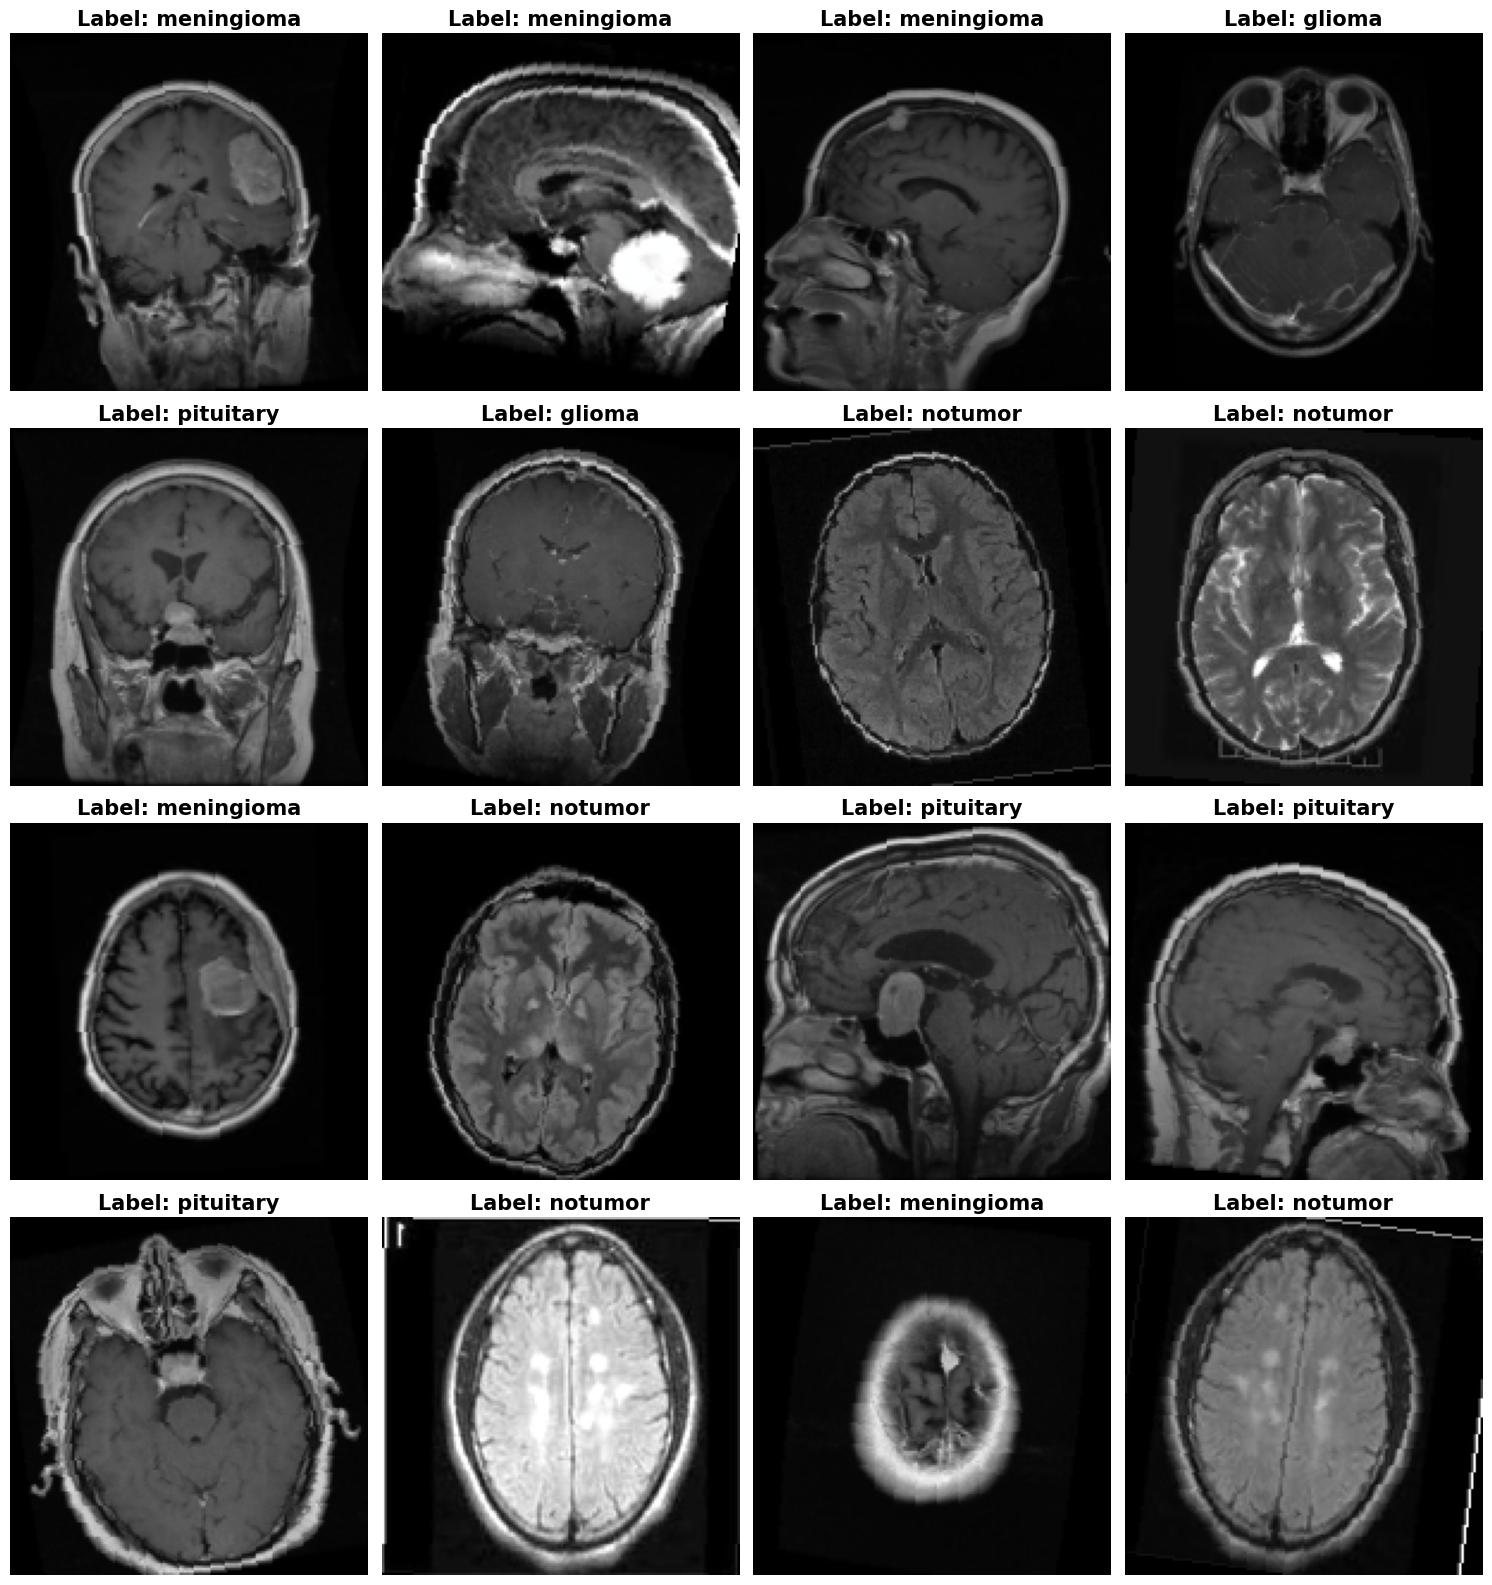

In [5]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

num_images = min(len(images), 16)
rows = 4 
fig, axes = plt.subplots(rows, 4, figsize = (15, 4 * rows)) 

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_data.classes[labels[i]]}', fontsize = 15, fontweight = 'bold')
        ax.axis('off')

for ax in axes.flat[num_images:]:
    ax.axis('off')

plt.tight_layout(pad = 1)
plt.show()

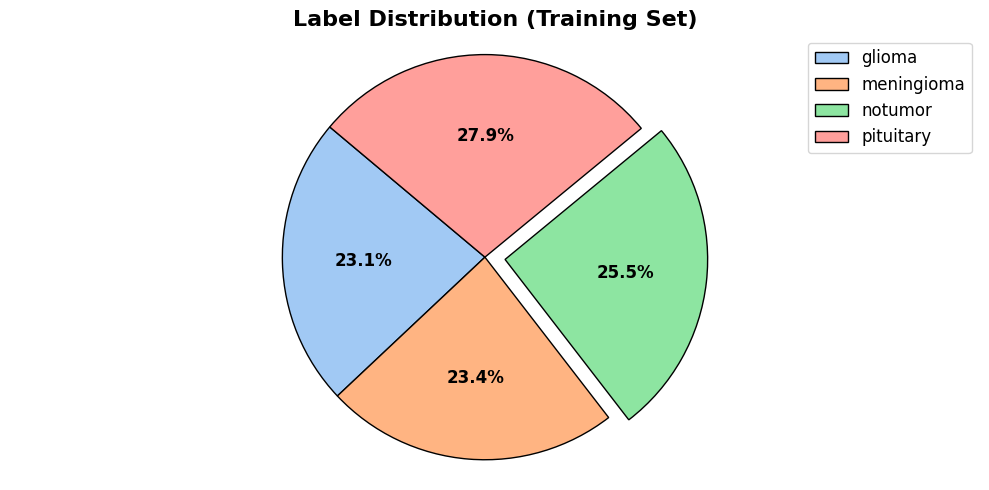

In [6]:
train_label_counts = {}
for _, labels in train_loader:
    for label in labels:
        label = label.item()
        train_label_counts[label] = train_label_counts.get(label, 0) + 1

class_names = train_data.classes

fig, ax = plt.subplots(figsize = (10, 5))

sizes_train = list(train_label_counts.values())
wedges_train, texts_train, autotexts_train = ax.pie(sizes_train, autopct = '%1.1f%%', 
                                                    startangle = 140, colors = sns.color_palette('pastel'), 
                                                    wedgeprops = dict(edgecolor = 'black'), 
                                                    explode = [0, 0, 0.1, 0])
ax.set_title('Label Distribution (Training Set)', fontsize = 16, fontweight = 'bold')
ax.axis('equal')
ax.legend(wedges_train, class_names, loc = 'best', fontsize = 12)

for text in texts_train:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts_train:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [7]:
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        self.feature_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 4, stride = 1, padding = 1),
            nn.ReLU(inplace = False),
            nn.MaxPool2d(kernel_size = 3),
            
            nn.Conv2d(32, 64, kernel_size = 4, stride = 1, padding = 1),
            nn.ReLU(inplace = False),
            nn.MaxPool2d(kernel_size = 3),
            
            nn.Conv2d(64, 128, kernel_size = 4, stride = 1, padding = 1),
            nn.ReLU(inplace = False),
            nn.MaxPool2d(kernel_size = 3)
        )
        
        self.flatten = nn.Flatten()
        
        self.dense_layers = nn.Sequential(
            nn.Linear(128 * 5 * 5, 512),
            nn.ReLU(inplace = False),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.feature_layers(x)
        x = self.flatten(x)
        x = self.dense_layers(x)
        return x
    
model = BrainTumorClassifier(num_classes = len(train_data.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
model_rlr = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.3, patience = 2, verbose = True)

print(model)

BrainTumorClassifier(
  (feature_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_layers): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [8]:
%%time

torch.manual_seed(0)

for epoch in tqdm(range(epochs)):
    start_time = time.time()
    
    train_accuracy = 0.0
    train_loss = 0.0
    
    model.train()
    
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        y_hat = model(inputs)
        loss = criterion(y_hat, labels)
        loss.backward()
        optimizer.step()
        
        _, predictions = torch.max(F.softmax(y_hat, dim = 1), 1)
        train_accuracy += accuracy(predictions, labels)
        train_loss += loss.item()
    
    train_accuracy /= len(train_loader)
    train_accuracies.append(train_accuracy)
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    test_accuracy = 0.0
    test_loss = 0.0
    
    model.eval()
    
    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            y_hat = model(inputs)
            loss = criterion(y_hat, labels)
            
            _, predictions = torch.max(F.softmax(y_hat, dim = 1), 1)
            test_accuracy += accuracy(predictions, labels)
            test_loss += loss.item()
            
        test_accuracy /= len(test_loader)
        test_accuracies.append(test_accuracy)
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
    
    elapsed_time = time.time() - start_time
    
    lr = optimizer.param_groups[0]['lr']
    
    print(f'Epoch {epoch + 1}/{epochs} | Learning Rate: {lr}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}')
    print(f'Elapsed Time: {elapsed_time:.2f} seconds\n')
    
    model_rlr.step(test_loss)
    
    if test_accuracy >= 0.98:
        print('\nDesired Accuracy Achieved!')
        break

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40 | Learning Rate: 0.001
Train Loss: 0.8023, Train Accuracy: 0.6629
Val Loss: 0.6017, Val Accuracy: 0.7759
Elapsed Time: 50.24 seconds

Epoch 2/40 | Learning Rate: 0.001
Train Loss: 0.4586, Train Accuracy: 0.8198
Val Loss: 0.4504, Val Accuracy: 0.8346
Elapsed Time: 44.43 seconds

Epoch 3/40 | Learning Rate: 0.001
Train Loss: 0.3353, Train Accuracy: 0.8787
Val Loss: 0.3651, Val Accuracy: 0.8628
Elapsed Time: 44.48 seconds

Epoch 4/40 | Learning Rate: 0.001
Train Loss: 0.2647, Train Accuracy: 0.9054
Val Loss: 0.2505, Val Accuracy: 0.9024
Elapsed Time: 44.50 seconds

Epoch 5/40 | Learning Rate: 0.001
Train Loss: 0.2152, Train Accuracy: 0.9181
Val Loss: 0.2408, Val Accuracy: 0.9078
Elapsed Time: 43.94 seconds

Epoch 6/40 | Learning Rate: 0.001
Train Loss: 0.1775, Train Accuracy: 0.9331
Val Loss: 0.1827, Val Accuracy: 0.9352
Elapsed Time: 43.99 seconds

Epoch 7/40 | Learning Rate: 0.001
Train Loss: 0.1347, Train Accuracy: 0.9506
Val Loss: 0.1620, Val Accuracy: 0.9512
Elapsed Time: 

In [9]:
true_labels = []
predicted_labels = []

with torch.inference_mode():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        y_hat = model(inputs)
        _, predictions = torch.max(F.softmax(y_hat, dim = 1), 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        
print(f'Test Accuracy Score: {accuracy(torch.tensor(predicted_labels), torch.tensor(true_labels))*100:.2f} %')

  0%|          | 0/41 [00:00<?, ?it/s]

Test Accuracy Score: 98.32 %


In [10]:
class_labels = list(test_data.classes)

print(f'Classification Report (Test) --> \n\n' + \
f'{classification_report(true_labels, predicted_labels, target_names = class_labels)}')

Classification Report (Test) --> 

              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98       300
  meningioma       0.96      0.97      0.97       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



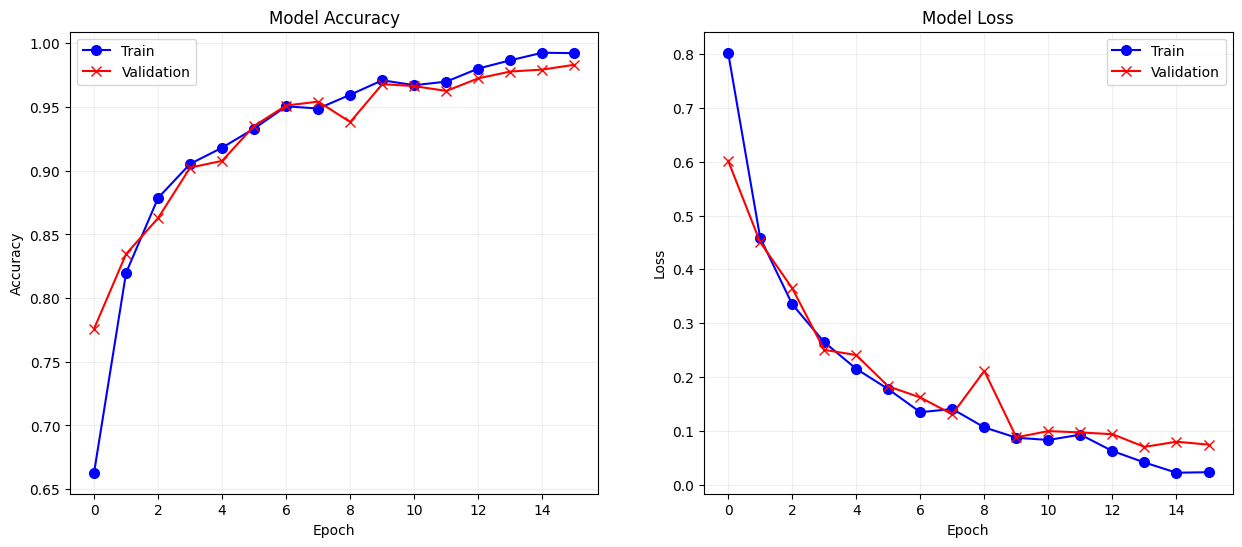

In [11]:
_, ax = plt.subplots(ncols = 2, figsize = (15, 6))

# accuracy

ax[0].plot(train_accuracies, marker = 'o', color = 'blue', markersize = 7)
ax[0].plot(test_accuracies, marker = 'x', color = 'red', markersize = 7)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha = 0.2)

# loss

ax[1].plot(train_losses, marker = 'o', color = 'blue', markersize = 7)
ax[1].plot(test_losses, marker = 'x', color = 'red', markersize = 7)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha = 0.2)

plt.show()

<Figure size 1000x1000 with 0 Axes>

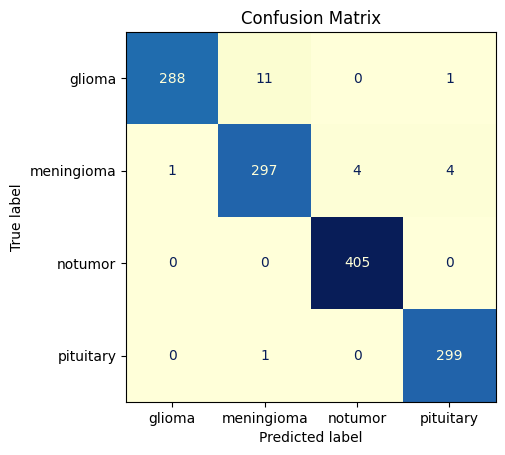

In [12]:
test_matrix = confusion_matrix(true_labels, predicted_labels)

disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

plt.figure(figsize = (10, 10))

disp_test.plot(cmap = 'YlGnBu', colorbar = False)
plt.title('Confusion Matrix')

plt.show()

In [13]:
# Define the path where the model will be saved
PATH = "brain_tumor_classifier_model.pth"

# Save the entire model
torch.save(model, PATH)
print("Model saved successfully!")


Model saved successfully!
